In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.fftpack
from mpl_toolkits.mplot3d import Axes3D

# import ipyvolume as ipv
%matplotlib inline
import micromagneticmodel as mm
import oommfc as oc

import discretisedfield as df
import discretisedfield.tools as dft

A common problem in magnetics is the study of the Heisenberg Hamiltonian in 3-D space, commonly on a regular lattice:

\begin{equation}
\mathcal{H} = -\frac{1}{2}\sum_{ij}S_{i} J_{ij} S_{j} - h \sum_{i} S_i - \sum_{i} S_i \sum_{j} \frac{3(S_j \cdot \hat{r}_{ij})\hat{r}_{ij}}{r_{ij}^5} - \frac{S_j}{r_{ij}^3}
\end{equation}

Commonly the dipolar field calculation is often neglected for large scale calculatiins because the computational complexity of calculating the interaction has $\mathcal{O}(N^2)$ complexity. In some cases, particularly where modelling 2-D systems, it is approximated by including an energy term in the Hamiltonian which has the same form as the Uniaxial Anisotropy, however it has been shown that in 3-D cases this is *not* sufficient, and can give incorrect results when modelling magnetisation dynamics with the Landau-Lifshitz-Gilbert equation. The dipolar interaction is crucial to the stabilisation of many interesting features in the magnetic field, such as domain walls, vortices and skyrmions.

In this notebook, we aim to show how the field can be calculated much more quickly, using a Fast Fourier Transform (FFT) convolution approach.

To start, lets consider a three-dimensional cubic lattice of spins, with $n_x \times n_y \times n_z$ in total.

If we index each axis as (i, j, k) We can give each spin a unique index, given by its position in the lattice, as
\begin{equation}
\text{I} = n_x\times n_y\times k + n_x\times j + i 
\end{equation}

The position of a given spin $I$ is then just given by:
\begin{equation}
\mathbf{r_I} = (i\,a_x, j\,a_y, k\,a_z)
\end{equation}
where $a_x, a_y, a_z$ are the distances between adjacent cubic unit cells along each coordinate axis.

Below, we just plot the magnetisation for a uniformly magnetised sample:

In [2]:
import numpy as np

nx = ny = nz = 5
lenx = 2 * nx - 1
leny = 2 * ny - 1
lenz = 2 * nz - 1
shape = (lenx, leny, lenz)
ax = 1
ay = 1
az = 1

np.random.seed(0)

mx = np.random.uniform(-1, 1, (nz, ny, nz))
my = np.random.uniform(-1, 1, (nz, ny, nz))
mz = np.random.uniform(-1, 1, (nz, ny, nz))
mod = np.sqrt(mx**2 + my**2 + mz**2)
mx /= mod
my /= mod
mz /= mod
# mx = np.ones((nx, ny, nz))
# my = np.ones((nx, ny, nz)) * 2
# mz = np.ones((nx, ny, nz)) * 3


Hx = np.zeros_like(mx)
Hy = np.zeros_like(my)
Hz = np.zeros_like(mz)

Hx_fft = np.zeros_like(mx)
Hy_fft = np.zeros_like(my)
Hz_fft = np.zeros_like(mz)

In [3]:
def H_direct(mx, my, mz, Hx, Hy, Hz):
    Hx[:] = 0
    Hy[:] = 0
    Hz[:] = 0
    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                for kp in range(nz):
                    for jp in range(ny):
                        for ip in range(nx):
                            x = (i - ip) * ax
                            y = (j - jp) * ay
                            z = (k - kp) * az
                            dr = np.sqrt(x**2 + y**2 + z**2)
                            # Spins don't interact with themselves, so skip if on same position
                            if dr == 0:
                                continue
                            r = np.array([x, y, z])
                            S = np.array(
                                [mx[kp, jp, ip], my[kp, jp, ip], mz[kp, jp, ip]]
                            )
                            H = 1e-7 * (3 * (r.dot(S)) * r / dr**5 - S / dr**3)
                            Hx[k, j, i] += H[0]
                            Hy[k, j, i] += H[1]
                            Hz[k, j, i] += H[2]


def Nxx_calc(x, y, z):
    x2 = x * x
    y2 = y * y
    z2 = z * z

    # x, y, z - coords in mesh
    # mesh.r(point, origin=pmin)
    r2 = x2 + y2 + z2

    return (2 * x2 - y2 - z2) / r2**2.5 if r2 != 0 else 0


def Nxy_calc(x, y, z):
    r2 = x * x + y * y + z * z

    return 3 * x * y / r2**2.5 if r2 != 0 else 0


def ComputeTensor(nx, ny, nz, ax, ay, az):
    lenx = 2 * nx - 1
    leny = 2 * ny - 1
    lenz = 2 * nz - 1
    total = lenx * leny * lenz
    shape = (lenx, leny, lenz)
    rshape = (lenx, leny, lenz // 2 + 1)
    Nxx = np.zeros(shape)
    Nxy = np.zeros_like(Nxx)
    Nxz = np.zeros_like(Nxx)
    Nyy = np.zeros_like(Nxx)
    Nyz = np.zeros_like(Nxx)
    Nzz = np.zeros_like(Nxx)
    for k in range(lenz):
        for i in range(lenx):
            for j in range(leny):
                # Notice that this spans the whole range of -nx*ax to nx*ax
                x = (i - nx + 1) * ax
                y = (j - ny + 1) * ay
                z = (k - nz + 1) * az
                Nxx[k, j, i] = Nxx_calc(x, y, z)
                Nyy[k, j, i] = Nxx_calc(y, x, z)
                Nzz[k, j, i] = Nxx_calc(z, y, x)
                Nxy[k, j, i] = Nxy_calc(x, y, z)
                Nxz[k, j, i] = Nxy_calc(x, z, y)
                Nyz[k, j, i] = Nxy_calc(y, z, x)
    print(Nxx.shape)
    Nxxt = np.fft.rfftn(Nxx)
    print(Nxxt.shape)
    Nxyt = np.fft.rfftn(Nxy)
    Nxzt = np.fft.rfftn(Nxz)
    Nyyt = np.fft.rfftn(Nyy)
    Nyzt = np.fft.rfftn(Nyz)
    Nzzt = np.fft.rfftn(Nzz)
    return (Nxx, Nxy, Nxz, Nyy, Nyz, Nzz), (Nxxt, Nxyt, Nxzt, Nyyt, Nyzt, Nzzt)


untransformed, tensor = ComputeTensor(nx, ny, nz, ax, ay, az)


def H_FFT(mx, my, mz, tensor, Hx, Hy, Hz):
    Hx[:] = 0
    Hy[:] = 0
    Hz[:] = 0
    Nxxt, Nxyt, Nxzt, Nyyt, Nyzt, Nzzt = tensor
    nz, ny, nx = mx.shape
    shape = (lenx, leny, lenz)
    mx_padded = np.zeros(shape)
    my_padded = np.zeros(shape)
    mz_padded = np.zeros(shape)
    mx_padded[:nx, :ny, :nz] = mx * 1e-7

    my_padded[:nx, :ny, :nz] = my * 1e-7
    mz_padded[:nx, :ny, :nz] = mz * 1e-7
    Mxt = np.fft.rfftn(mx_padded)
    Myt = np.fft.rfftn(my_padded)
    Mzt = np.fft.rfftn(mz_padded)

    Hxt = Nxxt * Mxt + Nxyt * Myt + Nxzt * Mzt
    Hyt = Nxyt * Mxt + Nyyt * Myt + Nyzt * Mzt
    Hzt = Nxzt * Mxt + Nyzt * Myt + Nzzt * Mzt
    hxc = np.fft.irfftn(Hxt, s=mx_padded.shape)
    hyc = np.fft.irfftn(Hyt, s=mx_padded.shape)
    hzc = np.fft.irfftn(Hzt, s=mx_padded.shape)

    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                Hx[k, j, i] = hxc[k + nz - 1, j + ny - 1, i + nx - 1]
                Hy[k, j, i] = hyc[k + nz - 1, j + ny - 1, i + nx - 1]
                Hz[k, j, i] = hzc[k + nz - 1, j + ny - 1, i + nx - 1]
    return hxc, hyc, hzc

(9, 9, 9)
(9, 9, 5)


In [4]:
mesh = df.Mesh(p1=(0, 0, 0), p2=(5, 5, 5), cell=(1, 1, 1))

In [5]:
def f(x, y, z):
    eps = 1e-18  # to avoid zero division; similar to Albert et al. 2015
    return (
        abs(y)
        / 2
        * (z**2 - x**2)
        * np.arcsinh(abs(y) / (np.sqrt(x**2 + z**2) + eps))
        + abs(z)
        / 2
        * (y**2 - x**2)
        * np.arcsinh(abs(z) / (np.sqrt(x**2 + y**2) + eps))
        - abs(x * y * z)
        * np.arctan(abs(y * z) / (abs(x) * np.sqrt(x**2 + y**2 + z**2) + eps))
        + 1 / 6 * (2 * x**2 - y**2 - z**2) * np.sqrt(x**2 + y**2 + z**2)
    )


def g(x, y, z):
    eps = 1e-18
    return (
        x * y * z * np.arcsinh(z / (np.sqrt(x**2 + y**2) + eps))
        + y
        / 6
        * (3 * z**2 - y**2)
        * np.arcsinh(x / (np.sqrt(y**2 + z**2) + eps))
        + x
        / 6
        * (3 * z**2 - x**2)
        * np.arcsinh(y / (np.sqrt(x**2 + z**2) + eps))
        - z**3 / 6 * np.arctan(x * y / (z * np.sqrt(x**2 + y**2 + z**2) + eps))
        - z
        * y**2
        / 2
        * np.arctan(x * z / (y * np.sqrt(x**2 + y**2 + z**2) + eps))
        - z
        * x**2
        / 2
        * np.arctan(y * z / (x * np.sqrt(x**2 + y**2 + z**2) + eps))
        - x * y * np.sqrt(x**2 + y**2 + z**2) / 3
    )


def N_element(x, y, z, mesh, function):
    dx, dy, dz = mesh.cell
    value = 0.0
    for i in np.rollaxis(np.indices((2,) * 6), 0, 7).reshape(64, 6):
        # print(x + (i[0] - i[3]) * dx, y + (i[1] - i[4]) * dy , z + (i[2] - i[5]) * dz, (-1)**np.sum(i), function(x + (i[0] - i[3]) * dx, y + (i[1] - i[4]) * dy , z + (i[2] - i[5]) * dz))
        value += (-1) ** np.sum(i) * function(
            x + (i[0] - i[3]) * dx, y + (i[1] - i[4]) * dy, z + (i[2] - i[5]) * dz
        )
    return -value / (4 * np.pi * np.prod(mesh.cell))


def N_calc_new(mesh):
    def _inner(p):
        x, y, z = p
        return (
            N_element(x, y, z, mesh, f),  # Nxx
            N_element(y, z, x, mesh, f),  # Nyy
            N_element(z, x, y, mesh, f),  # Nzz
            N_element(x, y, z, mesh, g),  # Nxy
            N_element(x, z, y, mesh, g),  # Nxz
            N_element(y, z, x, mesh, g),
        )  # Nyz

    return _inner

In [6]:
def Nxx_calc(x, y, z):
    x2 = x * x
    y2 = y * y
    z2 = z * z

    # x, y, z - coords in mesh
    # mesh.r(point, origin=pmin)
    r2 = x2 + y2 + z2

    return (2 * x2 - y2 - z2) / r2**2.5 if r2 != 0 else 0


def Nxy_calc(x, y, z):
    r2 = x * x + y * y + z * z

    return 3 * x * y / r2**2.5 if r2 != 0 else 0


def N_calc(p):
    x, y, z = p
    return (
        Nxx_calc(x, y, z),
        Nxx_calc(y, z, x),
        Nxx_calc(z, x, y),
        Nxy_calc(x, y, z),
        Nxy_calc(x, z, y),
        Nxy_calc(y, z, x),
    )


def ComputeTensor_new(mesh):
    p1 = [(-i + 1) * j - j / 2 for i, j in zip(mesh.n, mesh.cell)]
    p2 = [(i - 1) * j + j / 2 for i, j in zip(mesh.n, mesh.cell)]
    n = [2 * i - 1 for i in mesh.n]
    mesh_new = df.Mesh(p1=p1, p2=p2, n=n)

    return df.Field(mesh_new, dim=6, value=N_calc_new(mesh_new)).fftn
    # Nxxt, Nyyt, Nzzt, Nxyt, Nxzt, Nyzt
    #   0     1     2     3     4     5


def H_FFT(mx, my, mz, tensor, Hx, Hy, Hz):
    Hx[:] = 0
    Hy[:] = 0
    Hz[:] = 0
    Nxxt, Nxyt, Nxzt, Nyyt, Nyzt, Nzzt = tensor
    nz, ny, nx = mx.shape
    shape = (lenx, leny, lenz)
    mx_padded = np.zeros(shape)
    my_padded = np.zeros(shape)
    mz_padded = np.zeros(shape)
    mx_padded[:nx, :ny, :nz] = mx * 1e-7

    my_padded[:nx, :ny, :nz] = my * 1e-7
    mz_padded[:nx, :ny, :nz] = mz * 1e-7
    Mxt = np.fft.rfftn(mx_padded)
    Myt = np.fft.rfftn(my_padded)
    Mzt = np.fft.rfftn(mz_padded)

    Hxt = Nxxt * Mxt + Nxyt * Myt + Nxzt * Mzt
    Hyt = Nxyt * Mxt + Nyyt * Myt + Nyzt * Mzt
    Hzt = Nxzt * Mxt + Nyzt * Myt + Nzzt * Mzt
    hxc = np.fft.irfftn(Hxt, s=mx_padded.shape)
    hyc = np.fft.irfftn(Hyt, s=mx_padded.shape)
    hzc = np.fft.irfftn(Hzt, s=mx_padded.shape)

    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                Hx[k, j, i] = hxc[k + nz - 1, j + ny - 1, i + nx - 1]
                Hy[k, j, i] = hyc[k + nz - 1, j + ny - 1, i + nx - 1]
                Hz[k, j, i] = hzc[k + nz - 1, j + ny - 1, i + nx - 1]
    return hxc, hyc, hzc

In [7]:
m_field = df.Field(mesh, dim=3, value=np.stack((mx, my, mz), axis=3), norm=1)

In [8]:
system = mm.System(name="test")
system.m = m_field
system.energy = mm.Demag()

In [9]:
oc_field = oc.compute(system.energy.demag.effective_field, system)

Running OOMMF (ExeOOMMFRunner) [2021/08/03 17:50]... (1.1 s)


In [10]:
tensor_new = ComputeTensor_new(mesh)

In [11]:
tensor_dft = dft.demag_tensor(mesh)

In [12]:
def H_FFT_new(m, tensor):
    m_pad = m.pad(
        {d: (0, m.mesh.n[i] - 1) for d, i in zip(["x", "y", "z"], range(3))},
        mode="constant",
    )
    m_pad_fft = m_pad.fftn

    hx = (
        tensor.array[..., 0] * m_pad_fft.x.array.squeeze()
        + tensor.array[..., 3] * m_pad_fft.y.array.squeeze()
        + tensor.array[..., 4] * m_pad_fft.z.array.squeeze()
    )
    hy = (
        tensor.array[..., 3] * m_pad_fft.x.array.squeeze()
        + tensor.array[..., 1] * m_pad_fft.y.array.squeeze()
        + tensor.array[..., 5] * m_pad_fft.z.array.squeeze()
    )
    hz = (
        tensor.array[..., 4] * m_pad_fft.x.array.squeeze()
        + tensor.array[..., 5] * m_pad_fft.y.array.squeeze()
        + tensor.array[..., 2] * m_pad_fft.z.array.squeeze()
    )
    H = df.Field(m_pad_fft.mesh, dim=3, value=np.stack((hx, hy, hz), axis=3)).ifftn
    return df.Field(
        m.mesh,
        dim=3,
        value=H.array[m.mesh.n[0] - 1 :, m.mesh.n[1] - 1 :, m.mesh.n[2] - 1 :, :],
    ).real

In [13]:
H_new = H_FFT_new(m_field, tensor_new)

In [14]:
H_dft = dft.demag_field(m_field, tensor_dft)

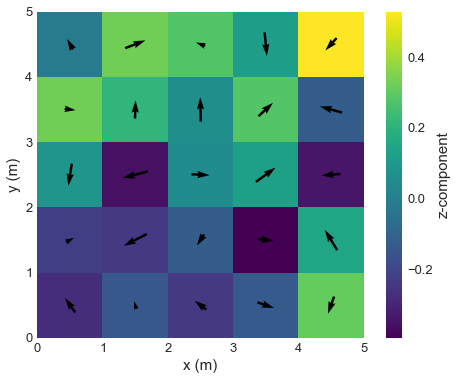

In [19]:
H_new.plane(z=1.5).mpl()

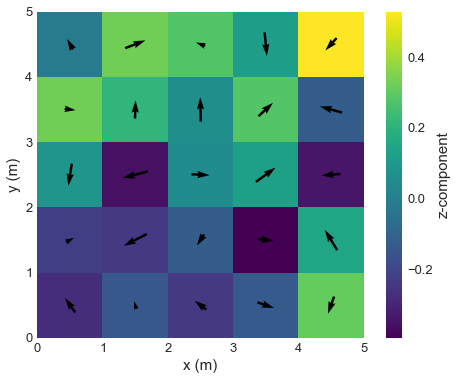

In [18]:
oc_field.plane(z=1.5).mpl()

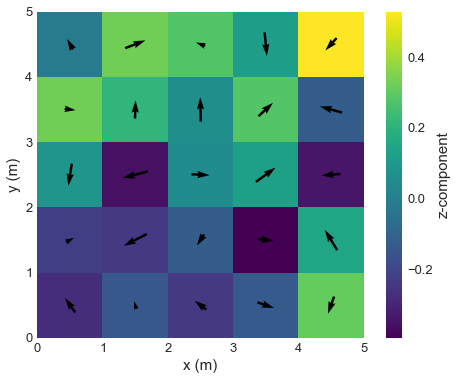

In [20]:
H_dft.plane(z=1.5).mpl()